<a href="https://colab.research.google.com/github/satoruk-icepp/MEG2XEC/blob/master/EnergyRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
! [ ! -z "$COLAB_GPU" ] && pip install skorch comet_ml
!pip install uproot
from comet_ml import Experiment

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as utils
from torch.utils.data.dataset import Subset
from torch.optim.lr_scheduler import MultiStepLR,StepLR,CyclicLR,CosineAnnealingLR
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import copy
from tqdm import tqdm, tqdm_notebook
import seaborn as sns
from IPython.display import clear_output
sns.set()

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)])

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
%%writefile .comet.config
[comet]
api_key=mIel5ZAPOioTs0Cij75dSSQXs
logging_file = /tmp/comet.log
logging_file_level = info


Overwriting .comet.config


In [5]:
experiment = Experiment(project_name="EneReg",log_code=True)
curtime = datetime.now().strftime("%Y%m%d-%H%M%S")
experiment.set_name("%s"%(curtime))
params={'batch_size' : 200,
        # 'train_size':20000,
        'val_size':500,
        'test_size':1000,
        # 'dropout_conv':0.3,
        'dropout_fc':0.05,
        'optim':"Adam",
        'weight_decay':1e-05,
        # 'Nresblock':0,
        # 'Nsd':0,
        # 'Wthreshold':np.log(0.2+1e-02)/2.5+1,
        # 'ethreshold':0.0,
        'weightstd':0.01,
        'NphoScale':10000,
        # 'Nfcnodes':128,
        'Nepoch':2000,
        # 'learning_rate':0.0000001,# for lr_test
        # 'LRgamma':10,# for lr_test
        # 'stepsize_lr':1, # for lr_test
        "LRtype":"Step",
        'learning_rate':0.01,
        # 'LRgamma':0.3,
        # 'LRgamma':0.5,
        'LRgamma':0.995,
        'milestones':[200,500,2000,5000,20000],
        # "LRtype":"MStep",
        # "LRtype":"Cyclic",
        # "LRtype":"CosA",
        # "LRtype":"CosExp",
        'stepsize_lr':1,
        'stepsize_lr_down':29,
        
        'base_lr':0.000001,
        'Erange':[15,20],
        'Urange':[-8,8],
        'Vrange':[-25,-5],
        'Wrange':[3,8],
        "run_train":353640
        # 'max_lr':0.005,
        
        # 'UseLPF':False,
        # 'DoBlind':False
}
experiment.log_parameters(params)

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/satoruk-icepp/enereg/f7c138a4f8f044798818e579e9ac0c55



In [0]:
import uproot
file = uproot.open("/content/drive/My Drive/MEG2CW/Gamma%d.root"%(params["run_train"]))
tout = file["tGamma"]

In [0]:
del file

In [8]:
tout.keys()

[b'uvw',
 b'uvwlpf',
 b'nphoarray',
 b'qmppcsumwf',
 b'qpmtsumwf',
 b'nsum2',
 b'npmt2',
 b'ninner2',
 b'energy']

In [9]:
uvwlpf = np.empty([0, 3])
energy = np.empty([0])
npho = np.empty([0,4760])

for data in tout.iterate(["energy", "nphoarray","uvwlpf"], namedecode="utf-8"):
    # operate on a batch of data in the loop
    # pos_selected = False
    # print(data["uvwlpf"][:,2])
    indx = (data["uvwlpf"][:,2]>params["Wrange"][0])\
            & (data["uvwlpf"][:,2]<params["Wrange"][1])\
            & (data["uvwlpf"][:,1]>params["Vrange"][0])\
            & (data["uvwlpf"][:,1]<params["Vrange"][1])\
            & (data["uvwlpf"][:,0]>params["Urange"][0])\
            & (data["uvwlpf"][:,0]<params["Urange"][1])
    
    uvwlpf = np.append(uvwlpf,data["uvwlpf"][indx],axis=0)
    energy = np.append(energy,data["energy"][indx],axis=0)
    npho   = np.append(npho,data["nphoarray"][indx]  ,axis=0)


317
431
895
1368
1883
2408
2865
3332
3795
4335
4833
5297
5801
6285
6755
7221
7731
8234
8738
9226
9753
10222
10709
11201
11695
12165
12649
13131
13614
14071
14542
15054
15521
16009
16489
16970
17463
17963
18424
18907
19258


In [0]:
npho = npho/params["NphoScale"]
data_size = len(energy)

In [11]:
energy_train,energy_val,energy_test = np.split(energy,[int(0.6*data_size),int(0.8*data_size)])
npho_train,npho_val,npho_test       = np.split(npho  ,[int(0.6*data_size),int(0.8*data_size)])
uvwlpf_train,uvwlpf_val,uvwlpf_test = np.split(uvwlpf,[int(0.6*data_size),int(0.8*data_size)])
print(len(npho_train),len(npho_val),len(npho_test))
indx_ene_train = (energy_train<params["Erange"][1]) & (energy_train>params["Erange"][0])
energy_train = energy_train[indx_ene_train]
npho_train   = npho_train[indx_ene_train]
uvwlpf_train = uvwlpf_train[indx_ene_train]
indx_ene_val = (energy_val<params["Erange"][1]) & (energy_val>params["Erange"][0])
energy_val = energy_val[indx_ene_val]
npho_val   = npho_val[indx_ene_val]
uvwlpf_val = uvwlpf_val[indx_ene_val]

# len(npho)

11554 3852 3852


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,  -7.6,  -7.2,  -6.8,
         -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,  -4. ,  -3.6,  -3.2,
         -2.8,  -2.4,  -2. ,  -1.6,  -1.2,  -0.8,  -0.4,   0. ,   0.4,
          0.8,   1.2,   1.6,   2. ,   2.4,   2.8,   3.2,   3.6,   4. ,
          4.4,   4.8,   5.2,   5.6,   6. ,   6.4,   6.8,   7.2,   7.6,
          8. ,   8.4,   8.8,   9.2,   9.6,  10. ]),
 array([-30. , -29.4, -28.8, -28.2, -27.6, -27. , -26.4, -25.8, -25.2,
        -24.6, -24. , -23.4, -22.8, -22.2, -21.6, -21. , -20.4, -19.8,
        -19.2, -18.6, -18. , -17.4, -16.8, -16.2, -15.6, -15. , -14.4,
        -13.8, -13.2, -12.6, -12. , -11.4, -10.8, -10.2,  -9.6,  -9. ,
         -8.4,  -7.8,  -7.2,  -6.6,  -6. ,  -5.4,  -4.8,  -4

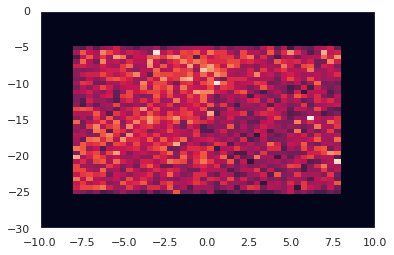

In [12]:
plt.hist2d(uvwlpf[:,0],uvwlpf[:,1],bins=[50,50],range=[[-10,10],[-30,0]])

8.120239652279647


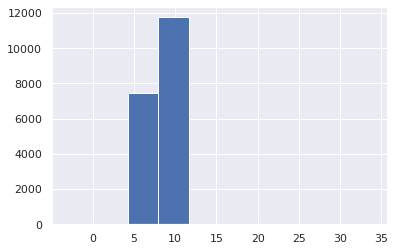

In [13]:
plt.hist(npho.sum(axis=1))
print(npho.sum(axis=1).mean())

(array([154., 163., 207., 205., 235., 305., 302., 367., 414., 417., 457.,
        477., 419., 455., 417., 402., 364., 297., 260., 208., 153., 113.,
         80.,  55.,  40.,  26.,  18.,  15.,   6.,   4.,   7.,   5.,   2.,
          2.,   2.,   2.,   3.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   2.]),
 array([15.00007265, 15.09922129, 15.19836994, 15.29751859, 15.39666723,
        15.49581588, 15.59496452, 15.69411317, 15.79326181, 15.89241046,
        15.9915591 , 16.09070775, 16.1898564 , 16.28900504, 16.38815369,
        16.48730233, 16.58645098, 16.68559962, 16.78474827, 16.88389691,
        16.98304556, 17.08219421, 17.18134285, 17.2804915 , 17.37964014,
        17.47878879, 17.57793743, 17.67708608, 17.77623472, 17.87538337,
        17.97453202, 18.07368066, 18.17282931, 18.27197795, 18.3711266 ,
        18.47027524, 18.56942389, 18.66857253, 18.76772118, 18.86686983,
        18.96601847, 19.06516712, 19.16431576, 19.26346441, 19.36261305,
 

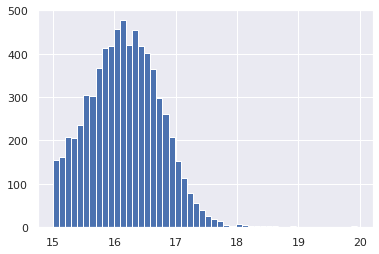

In [14]:
plt.hist(energy_train,bins=50)

In [0]:
def normal_init(m, mean, std):
    if isinstance(m, (nn.Linear, nn.Conv2d, nn.BatchNorm2d, nn.BatchNorm1d)):
        m.weight.data.normal_(mean, std)
        if m.bias is not None:
            if m.bias.data is not None:
                m.bias.data.zero_()

In [0]:
class reg(nn.Module):
    def __init__(self,dropout=0):
        super(reg,self).__init__()
        self.linear = nn.Linear(4760,1,False)
        self.dropout = nn.Dropout(dropout);

    def forward(self,x):
        x = self.linear(self.dropout(x))
        return x

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

In [0]:
# reg = nn.Sequential(nn.Linear(2, 1,False))
loss_fn = torch.nn.SmoothL1Loss().to(device)

In [0]:
model = reg(params["dropout_fc"]).to(device)
model.weight_init(mean=1e-04,std=1e-05)
opt = optim.Adam(model.parameters(), lr=params["learning_rate"])
if params["LRtype"]=="Cyclic":
    scheduler = CyclicLR(opt, params["base_lr"],params["learning_rate"],
                         step_size_up=params["stepsize_lr"],
                         step_size_down=params["stepsize_lr_down"],
                         cycle_momentum=False,mode="exp_range",gamma = params["LRgamma"])
elif params["LRtype"]=="MStep":
    scheduler = MultiStepLR(opt, milestones=params["milestones"], gamma=params["LRgamma"])
elif params["LRtype"]=="Step":
    scheduler = StepLR(opt,step_size=params["stepsize_lr"],gamma=params["LRgamma"])
elif params["LRtype"]=="CosA":
    scheduler = CosineAnnealingLR(opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"])
# elif params["LRtype"]=="CosExp":
#     scheduler = CosineExpLR(opt,T_max=params["stepsize_lr"],eta_min=params["base_lr"],gamma = params["LRgamma"])

In [0]:
energy_train = torch.tensor(energy_train).float()
npho_train = torch.tensor(npho_train).float()
energy_val = torch.tensor(energy_val).float()
npho_val = torch.tensor(npho_val).float()

In [0]:
BATCH_SIZE = params["batch_size"]
# BATCH_SIZE = 100
# calo_dataset    = utils.TensorDataset(energy,npho)
# data_size =  len(calo_dataset)
# full_size = int(data_size//1000)*1000
# val_size = params["val_size"]
# print(data_size)
# indx_train = list(range(0,full_size-val_size))
# indx_val   = list(range(full_size-val_size,full_size))
# train_dataset = Subset(calo_dataset,indx_train)
# val_dataset   = Subset(calo_dataset,indx_val)
train_dataset = utils.TensorDataset(energy_train,npho_train)
val_dataset   = utils.TensorDataset(energy_val,npho_val)
# train_dataset = Subset(calo_dataset,list(range(0,params["train_size"])))
# val_dataset = Subset(calo_dataset,list(range(params["train_size"],params["train_size"]+params["val_size"])))
train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              pin_memory=True, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                              batch_size=BATCH_SIZE, 
                                              pin_memory=True, shuffle=True)

In [21]:
# batch_size=10
ibatch = 0
for i in range(params["Nepoch"]):
    with experiment.train():
        model.train()
        for energy_b,npho_b in train_dataloader:
                # moving them to device(for example, cuda-device)
            energy_b,npho_b = energy_b.to(device), \
                            npho_b.to(device)
        # real_data = sample_real_data(batch_size)
            
            pred = model(npho_b)
            target = (torch.ones(pred.shape[0])*17.6).to(device)
            loss        = loss_fn(pred, target)
            
            opt.zero_grad()
            loss.backward()
            opt.step()
            # if ibatch%10==0: print(ibatch)
            ibatch +=1

        scheduler.step()
        experiment.log_metric("loss", loss.item(),step=i)
        experiment.log_metric("learning_rate", scheduler.get_lr(),step=i)

    with experiment.test():
        model.eval()
        for energy_b,npho_b in val_dataloader:
                # moving them to device(for example, cuda-device)
            energy_b,npho_b = energy_b.to(device), \
                            npho_b.to(device)
            pred = model(npho_b)
            target = (torch.ones(pred.shape[0])*17.6).to(device)
            val_loss        = loss_fn(pred, target)
            break
        experiment.log_metric("loss", val_loss.item(),step=i)


    if i%10==0:
        plt.hist(energy_b.cpu().detach().numpy(),bins=50,range=(15,20),histtype='step',fill=False,edgecolor='b',label='nsum2')
        plt.hist(pred.cpu().detach().numpy(),bins=50,range=(15,20),histtype='step',fill=False,edgecolor='r',label='pred')
        plt.legend(loc="upper left")
        experiment.log_figure(figure=plt)
        plt.close()
        
        
        
# print(loss.item(),pred,model.linear.weight)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:782: UserWarning: Using a target size (torch.Size([200])) that is different to the input size (torch.Size([200, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)
/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:782: UserWarning: Using a target size (torch.Size([63])) that is different to the input size (torch.Size([63, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.smooth_l1_loss(input, target, reduction=self.reduction)


In [0]:
model.eval()
pred_test = model.cpu()(torch.tensor(npho_test).float()).cpu().detach().numpy()
# prediction_test = regressor.cpu()(torch.tensor(EnergyDeposit_test).float())

(array([  0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   0.,   0.,
          0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   1.,   1.,   4.,   3.,   5.,  12.,  21.,
         25.,  30.,  29.,  31.,  47.,  39.,  51.,  65.,  76.,  88.,  93.,
        102., 112., 112., 124., 108.,  99.,  89.,  84.,  95., 105., 120.,
        166., 214., 261., 296., 298., 305., 197., 136.,  84.,  56.,  32.,
         11.,   3.,   4.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   0.,
          0.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
         6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
         8.8,  9. ,  9

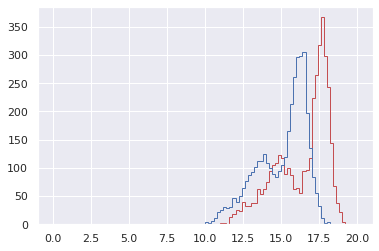

In [23]:
# indx_w = (uvwlpf[:,2]>2)&(uvwlpf[:,2]<5)&(uvwlpf[:,1]>-20)&(uvwlpf[:,1]<-10)
# indx_pos = (uvwlpf[:,2]>2) & (uvwlpf[:,2]<10) & (uvwlpf[:,1]<-10) & (uvwlpf[:,1]>-20) & (uvwlpf[:,0]>-5) & (uvwlpf[:,0]<5)
n,bins,_ = plt.hist(pred_test,range=(0,20),bins=100,histtype='step',fill=False,edgecolor='r',label='pred')
plt.hist(energy_test,range=(0,20),bins=100,histtype='step',fill=False,edgecolor='b',label='raw')

In [0]:
# Fit functions
def Gaussian(x,a,b,c):
    return a * np.exp(-(x - b)**2.0 / (2 * c**2))

[False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False False False False False False False False False False False
 False False  True  True  True  True  True  True  True  True  True  True
  True  True  True  True]
[351.66222749  17.66865088   0.47611007]


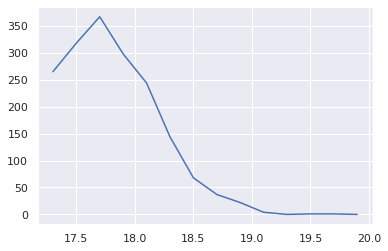

In [25]:
from scipy.optimize import curve_fit
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
# popt, pcov = curve_fit(Gaussian,binscenters,n,bounds=(15,20)) 
indx_bin = binscenters>17.2
# indx_bin = binscenters>0
print(indx_bin)
binscenters_fit = binscenters[indx_bin]
n_fit = n[indx_bin]
plt.plot(binscenters_fit,n_fit)
popt, pcov = curve_fit(Gaussian,binscenters_fit,n_fit,bounds = ((10,16,0),(1e6,18,3))) 
print(popt)

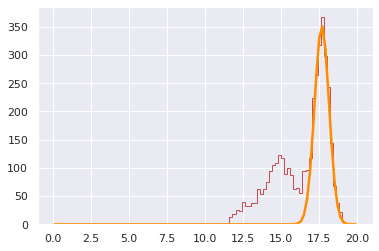

In [26]:
plt.hist(pred_test,range=(0,20),bins=100,histtype='step',fill=False,edgecolor='r',label='pred')
plt.plot(binscenters, Gaussian(binscenters, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')

(19258,)


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ,
         2.2,  2.4,  2.6,  2.8,  3. ,  3.2,  3.4,  3.6,  3.8,  4. ,  4.2,
         4.4,  4.6,  4.8,  5. ,  5.2,  5.4,  5.6,  5.8,  6. ,  6.2,  6.4,
         6.6,  6.8,  7. ,  7.2,  7.4,  7.6,  7.8,  8. ,  8.2,  8.4,  8.6,
         8.8,  9. ,  9.2,  9.4,  9.6,  9.8, 10. , 10.2, 10.4, 10.6, 10.8,
        11. , 11.2, 11.4, 11.6, 11.8, 12. , 12.2, 12.4, 12.6, 12.8, 13. ,
        13.2, 13.4, 13.6, 13.8, 14. , 14.2, 14.4, 14.6, 14.8, 15. , 15.2,
        15.4, 15.6, 15.8, 16. , 16.2, 16.4, 16.6, 16.8, 17. , 17.2, 17.4,
        17.6, 17.8, 18. , 18.2, 18.4, 18.6, 18.8, 19. , 19.2, 19.4, 19.6,
        19.8, 20. ]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  

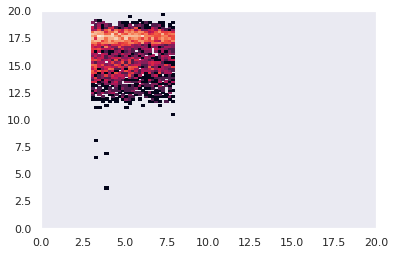

In [27]:
print(uvwlpf[:,2].shape)
from matplotlib.colors import LogNorm
plt.hist2d(uvwlpf_test[:,2],pred_test[:,0],range=[[0,20],[0,20]],bins=[100,100],norm=LogNorm())
# plt.hist2d(uvwlpf[:,2],pred_test[:,0].cpu().detach().numpy(),range=[[0,20],[0,20]],bins=[100,100])

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-40. , -39.6, -39.2, -38.8, -38.4, -38. , -37.6, -37.2, -36.8,
        -36.4, -36. , -35.6, -35.2, -34.8, -34.4, -34. , -33.6, -33.2,
        -32.8, -32.4, -32. , -31.6, -31.2, -30.8, -30.4, -30. , -29.6,
        -29.2, -28.8, -28.4, -28. , -27.6, -27.2, -26.8, -26.4, -26. ,
        -25.6, -25.2, -24.8, -24.4, -24. , -23.6, -23.2, -22.8, -22.4,
        -22. , -21.6, -21.2, -20.8, -20.4, -20. , -19.6, -19.2, -18.8,
        -18.4, -18. , -17.6, -17.2, -16.8, -16.4, -16. , -15.6, -15.2,
        -14.8, -14.4, -14. , -13.6, -13.2, -12.8, -12.4, -12. , -11.6,
        -11.2, -10.8, -10.4, -10. ,  -9.6,  -9.2,  -8.8,  -8.4,  -8. ,
         -7.6,  -7.2,  -6.8,  -6.4,  -6. ,  -5.6,  -5.2,  -4.8,  -4.4,
         -4. ,  -3.6,  -3.2,  -2.8,  -2.4

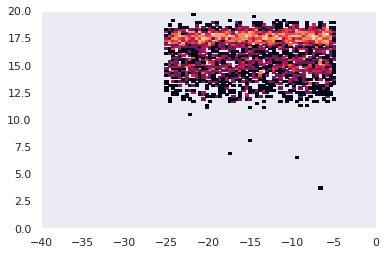

In [28]:
plt.hist2d(uvwlpf_test[:,1],pred_test[:,0],range=[[-40,0],[0,20]],bins=[100,100],norm=LogNorm())

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-10. ,  -9.8,  -9.6,  -9.4,  -9.2,  -9. ,  -8.8,  -8.6,  -8.4,
         -8.2,  -8. ,  -7.8,  -7.6,  -7.4,  -7.2,  -7. ,  -6.8,  -6.6,
         -6.4,  -6.2,  -6. ,  -5.8,  -5.6,  -5.4,  -5.2,  -5. ,  -4.8,
         -4.6,  -4.4,  -4.2,  -4. ,  -3.8,  -3.6,  -3.4,  -3.2,  -3. ,
         -2.8,  -2.6,  -2.4,  -2.2,  -2. ,  -1.8,  -1.6,  -1.4,  -1.2,
         -1. ,  -0.8,  -0.6,  -0.4,  -0.2,   0. ,   0.2,   0.4,   0.6,
          0.8,   1. ,   1.2,   1.4,   1.6,   1.8,   2. ,   2.2,   2.4,
          2.6,   2.8,   3. ,   3.2,   3.4,   3.6,   3.8,   4. ,   4.2,
          4.4,   4.6,   4.8,   5. ,   5.2,   5.4,   5.6,   5.8,   6. ,
          6.2,   6.4,   6.6,   6.8,   7. ,   7.2,   7.4,   7.6,   7.8,
          8. ,   8.2,   8.4,   8.6,   8.8

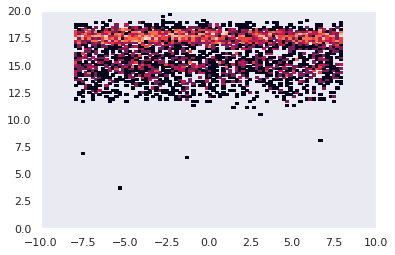

In [29]:
plt.hist2d(uvwlpf_test[:,0],pred_test[:,0],range=[[-10,10],[0,20]],bins=[100,100],norm=LogNorm())

In [30]:
plt.hist2d(uvwlpf[:,2],energy_raw,range=[[0,40],[0,20]],bins=[100,100])

NameError: ignored

In [0]:
x = [i for i in range(4760)]
# v = []
print(model.linear.weight.cpu().detach().numpy())
# for param in model.parameters():
    # v.append(param.data[0])

# plt.scatter(x,model.linear.weight.cpu().detach().numpy(),vmin=-0.001,vmax=0.001,c="r")
plt.hist(model.linear.weight[0].cpu().detach().numpy(),range=(0,4e-4),bins=80)
    # for weight in param.data[0]:
    #     print(weight)

In [0]:
file_uslit = uproot.open("/content/drive/My Drive/MEG2CW/Gamma330471.root")
tout_uslit = file_uslit["tGamma"]

In [0]:
energy_uslit = tout_uslit.array("energy")
npho_uslit = tout_uslit.array("nphoarray")
uvwlpf_uslit = tout_uslit.array("uvwlpf")

npho_uslit = npho_uslit/params["NphoScale"]

In [0]:
del npho_raw
del npho
del tout
del calo_dataset
del file

In [0]:
indx_pos_uslit =(uvwlpf_uslit[:,2]>params["Wrange"][0])\
& (uvwlpf_uslit[:,2]<params["Wrange"][1]) \
& (uvwlpf_uslit[:,1]>params["Vrange"][0])\
& (uvwlpf_uslit[:,1]<params["Vrange"][1])\
& (uvwlpf_uslit[:,0]>params["Urange"][0])\
& (uvwlpf_uslit[:,0]<params["Urange"][1])

In [0]:
pred_uslit = model.cpu()(torch.tensor(npho_uslit).float()).cpu().detach().numpy()

In [0]:
n,bins,_ = plt.hist(pred_uslit[indx_pos_uslit],range=(0,20),bins=100,histtype='step',fill=False,edgecolor='r',label='pred')
plt.hist(energy_uslit[indx_pos_uslit],range=(0,20),bins=100,histtype='step',fill=False,edgecolor='b',label='pred')

In [0]:
# Fit functions
def Gaussian(x,a,b,c):
    return a * np.exp(-(x - b)**2.0 / (2 * c**2))

In [0]:
from scipy.optimize import curve_fit
binscenters = np.array([0.5 * (bins[i] + bins[i+1]) for i in range(len(bins)-1)])
# popt, pcov = curve_fit(Gaussian,binscenters,n,bounds=(15,20)) 
indx_bin = binscenters>17
# indx_bin = binscenters>0
print(indx_bin)
binscenters_fit = binscenters[indx_bin]
n_fit = n[indx_bin]
plt.plot(binscenters_fit,n_fit)
popt, pcov = curve_fit(Gaussian,binscenters_fit,n_fit,bounds = ((10,16,0),(1e6,18,3))) 
print(popt)

In [0]:
plt.hist(pred_uslit[indx_pos_uslit],range=(0,20),bins=100,histtype='step',fill=False,edgecolor='r',label='pred')
plt.plot(binscenters, Gaussian(binscenters, *popt), color='darkorange', linewidth=2.5, label=r'Fitted function')

In [0]:
plt.hist2d(uvwlpf_uslit[:,2],pred_uslit[:,0],range=[[0,40],[16,20]],bins=[100,100],norm=LogNorm())
# print(pred_uslit.shape)
# plt.hist2d(pred_uslit,pred_uslit,range=[[0,40],[0,20]],bins=[100,100])